In [4]:
from matplotlib import pyplot as plt
from scipy.stats import linregress
import numpy as np
from sklearn import datasets
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import scipy.stats as stats

import dataframe_image as dfi

In [5]:
df = pd.read_csv("../../Data/CleanData_mileage_price_enginesize.csv")

df.head()



,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,Aygo,2017,9250,Manual,4414,Other,150,68.9,1.0
1,Aygo,2017,7100,Manual,32351,Petrol,0,68.9,1.0
2,Aygo,2016,6500,Manual,26193,Petrol,0,69.0,1.0
3,Aygo,2017,7650,Manual,12134,Petrol,0,68.9,1.0
4,Aygo,2016,6999,Manual,21123,Petrol,0,69.0,1.0


In [3]:
dfi.export(df.head(),"..\\..\\clean_data.png")


# Is there more price variation within a brand of car or between brands?

## Normality Assumption Check

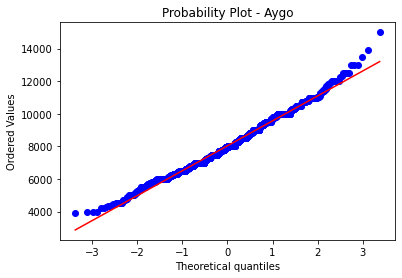

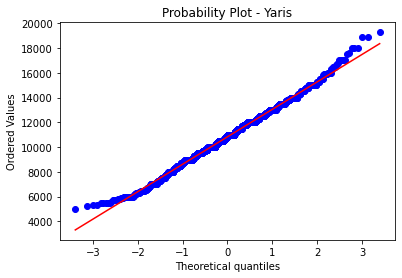

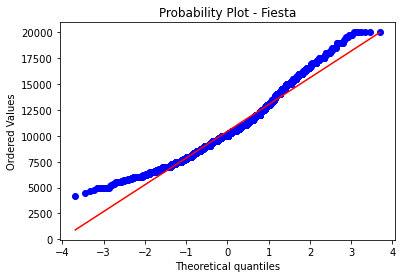

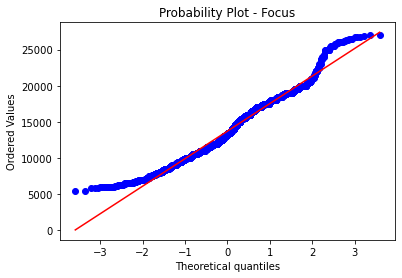

In [6]:
#https://towardsdatascience.com/anova-test-with-python-cfbf4013328b

models = df['model'].unique()
for model in models:
    stats.probplot(df[df['model'] == model]['price'], dist="norm", plot=plt)
    plt.title("Probability Plot - " +  model)
    plt.show()

## Homogeneity of variance Assumption Check

In [7]:
ratio = df.groupby('model').std().max() / df.groupby('model').std().min()
ratio

year          1.120895
price         2.505957
mileage       1.196465
tax           1.160395
mpg           2.240336
engineSize         inf
dtype: float64

## Borderline in terms of meeting the homogeneity of varianace assumption

## Hypothesis Testing

In [8]:
# Create ANOVA backbone table
data = [['Between Groups', '', '', '', '', '', ''], ['Within Groups', '', '', '', '', '', ''], ['Total', '', '', '', '', '', '']] 
anova_table = pd.DataFrame(data, columns = ['Source of Variation', 'SS', 'df', 'MS', 'F', 'P-value', 'F crit']) 
anova_table.set_index('Source of Variation', inplace = True)

# calculate SSTR and update anova table
x_bar = df['price'].mean()
SSTR = df.groupby('model').count() * (df.groupby('model').mean() - x_bar)**2
anova_table['SS']['Between Groups'] = SSTR['price'].sum()

# calculate SSE and update anova table
SSE = (df.groupby('model').count() - 1) * df.groupby('model').std()**2
anova_table['SS']['Within Groups'] = SSE['price'].sum()

# calculate SSTR and update anova table
SSTR = SSTR['price'].sum() + SSE['price'].sum()
anova_table['SS']['Total'] = SSTR

# update degree of freedom
anova_table['df']['Between Groups'] = df['model'].nunique() - 1
anova_table['df']['Within Groups'] = df.shape[0] - df['model'].nunique()
anova_table['df']['Total'] =df.shape[0] - 1

# calculate MS
anova_table['MS'] = anova_table['SS'] / anova_table['df']

# calculate F 
F = anova_table['MS']['Between Groups'] / anova_table['MS']['Within Groups']
anova_table['F']['Between Groups'] = F

# p-value
anova_table['P-value']['Between Groups'] = 1 - stats.f.cdf(F, anova_table['df']['Between Groups'], anova_table['df']['Within Groups'])

# F critical 
alpha = 0.05
# possible types "right-tailed, left-tailed, two-tailed"
tail_hypothesis_type = "two-tailed"
if tail_hypothesis_type == "two-tailed":
    alpha /= 2
anova_table['F crit']['Between Groups'] = stats.f.ppf(1-alpha, anova_table['df']['Between Groups'], anova_table['df']['Within Groups'])

# Final ANOVA Table
anova_table

,SS,df,MS,F,P-value,F crit
Source of Variation,,,,,,
Between Groups,49186796415.574593,3,16395598805.19153,1968.301148,0.0,3.117049
Within Groups,118525041551.405396,14229,8329822.303142,,,
Total,167711837966.97998,14232,11784137.012857,,,


In [9]:
dfi.export(anova_table,"..\\..\\anova_table.png")

In [17]:
# The p-value approach
print("Approach 1: The p-value approach to hypothesis testing in the decision rule")
conclusion = "Failed to reject the null hypothesis."
if anova_table['P-value']['Between Groups'] <= alpha:
    conclusion = "Null Hypothesis is rejected."
print("F-score is:", anova_table['F']['Between Groups'], " and p value is:", anova_table['P-value']['Between Groups'])    
print(conclusion)

Approach 1: The p-value approach to hypothesis testing in the decision rule
F-score is: 1968.3011483939365  and p value is: 1.1102230246251565e-16
Null Hypothesis is rejected.


In [12]:
df2 = df.groupby("model").agg({"price": ["mean", "std", "var", "count"]}, axis=1)

In [13]:
dfi.export(df2,"..\\..\\model_price.png")

In [20]:
group1 = df[df["model"] == "Aygo"]["price"]
group2 = df[df["model"] == "Fiesta"]["price"]
group3 = df[df["model"] == "Focus"]["price"]
group4 = df[df["model"] == "Yaris"]["price"]

In [21]:
stats.f_oneway(group1, group2, group3, group4)

F_onewayResult(statistic=1968.3011483939333, pvalue=0.0)

In [22]:
print(stats.ttest_ind(group1, group2, equal_var=False))
print(stats.ttest_ind(group1, group3, equal_var=True))
print(stats.ttest_ind(group1, group4, equal_var=False))

print(stats.ttest_ind(group2, group3, equal_var=False))
print(stats.ttest_ind(group2, group4, equal_var=True))

print(stats.ttest_ind(group3, group4, equal_var=False))

Ttest_indResult(statistic=-49.395735208981066, pvalue=0.0)
Ttest_indResult(statistic=-61.964700033848835, pvalue=0.0)
Ttest_indResult(statistic=-45.988905425489676, pvalue=0.0)
Ttest_indResult(statistic=-48.08611636716135, pvalue=0.0)
Ttest_indResult(statistic=-6.048692808286863, pvalue=1.5244509953093368e-09)
Ttest_indResult(statistic=37.32761108786972, pvalue=2.2538578977462175e-274)


## The groups are statistical different in price based on an ANOVA test and statistically different from each other based on the t-tests performed